In [1]:
import pandas as pd
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from datetime import datetime
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from tqdm import tqdm
from obspy.geodetics import locations2degrees, degrees2kilometers

## Morton Catalog

In [33]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog that occurred on 10/14/2012
t1 = pd.Timestamp('2012-10-01 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2012-10-31 23:59:59.999999+0000', tz='UTC')

events_morton_201210= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton_201210.head()

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
630,2.0,2.012100e+13,2012.0,10.0,1.0,4.0,32.0,57.05,40.7190,-125.9525,...,34.0,0.46,2.6,29.2,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-01 04:32:57+00:00
631,2.0,2.012100e+13,2012.0,10.0,1.0,23.0,30.0,58.38,40.5787,-124.8887,...,11.8,0.34,6.9,5.8,NaN,NaN,NaN,Slab,NaN,2012-10-01 23:30:58+00:00
632,2.0,2.012100e+13,2012.0,10.0,2.0,4.0,25.0,46.37,40.5592,-125.2087,...,24.1,0.30,1.7,5.0,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-02 04:25:46+00:00
633,2.0,2.012100e+13,2012.0,10.0,2.0,5.0,16.0,28.35,40.5075,-124.5450,...,7.3,0.35,1.1,1.2,NaN,NaN,NaN,Slab,NaN,2012-10-02 05:16:28+00:00
634,2.0,2.012100e+13,2012.0,10.0,2.0,6.0,17.0,18.88,40.4213,-125.3963,...,31.2,0.46,1.4,34.8,316.59,43.54,-85.95,Seaward of Trench,NaN,2012-10-02 06:17:18+00:00


In [3]:
events_morton['datetime'].max()

Timestamp('2015-10-07 21:45:50+0000', tz='UTC')

In [4]:
events_morton_201210.keys()

Index(['CI YEAR', 'TSTRING', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE',
       'SECOND', 'LAT', 'LON', 'DEPTH', 'Md', 'Num P&S with weights > 0.1',
       'max az gap', 'dist to nearest stn', 'tt RMS', 'ERH', 'ERZ', 'STRIKE',
       'DIP', 'RAKE', 'PLATE DESIGNATION', 'TEMPLATE EVENT?', 'datetime'],
      dtype='object')

In [5]:
len(events_morton_201210)

91

## Our Catalog

In [34]:
# Load all the pick assignments 
mycatalog_picks = pd.read_csv('../data/all_pick_assignments_201210.csv')
mycatalog = mycatalog_picks.drop_duplicates(subset=['idx'])
# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
mycatalog=mycatalog.loc[(mycatalog['datetime'] > t1) & (mycatalog['datetime'] < t2) ]
mycatalog.head()

/tmp/ipykernel_263687/778102704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)


,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2012-10-01 04:32:56.834786+00:00,-36.801756,-416.426130,37.890625,21,40.750478,-125.935772,37.890625,0,153772,0.891797,FS01B,P,1.349066e+09,2012-10-01 04:32:56.834786+00:00
21,21,1,2012-10-01 06:06:25.601846+00:00,104.483147,-425.999093,25.390625,9,40.658485,-124.264521,25.390625,1,554952,-0.426542,FS04B,S,1.349072e+09,2012-10-01 06:06:25.601846+00:00
30,30,2,2012-10-01 06:49:32.006296+00:00,62.182278,-443.948400,33.984375,16,40.501128,-124.766430,33.984375,2,86563,0.851777,BB030,P,1.349074e+09,2012-10-01 06:49:32.006296+00:00
46,46,3,2012-10-01 06:55:58.805940+00:00,79.102626,-479.847012,27.734375,10,40.176440,-124.571285,27.734375,3,153785,-0.829479,FS01B,P,1.349075e+09,2012-10-01 06:55:58.805940+00:00
56,56,4,2012-10-01 07:27:43.834659+00:00,74.026521,-458.307844,36.328125,23,40.370857,-124.628388,36.328125,4,153787,-0.192129,FS01B,P,1.349076e+09,2012-10-01 07:27:43.834659+00:00


In [35]:
len(mycatalog)

1039

In [32]:
len(mycatalog_picks)

16356

## Not necessary anymore

In [37]:
# original loop for matching 
matched_events_mycatalog= []
matched_times_morton = []
# matched_time_mycatalog = []
matched_events_morton = []
unmatched_times_morton = []
unmatched_events_morton = []
unmatched_events_mycatalog = []
time_threshold = 5

lat_morton=[]
lon_morton=[]

for i in range(len(events_morton_201210)):
    
    t11 = events_morton_201210.iloc[i]['datetime']
    matched_df = mycatalog.loc[(mycatalog['datetime'] >= t11 - pd.Timedelta(time_threshold,'seconds')) & 
                               (mycatalog['datetime'] <= t11 +pd.Timedelta(time_threshold,'seconds')) ]
    
    unmatched_df = mycatalog.loc[~((mycatalog['datetime'] >= t11 - pd.Timedelta(time_threshold,'seconds')) & 
                               (mycatalog['datetime'] <= t11 +pd.Timedelta(time_threshold,'seconds'))) ]
    if i == 0:
        print(unmatched_df)
    
    # If there is only one match, append the time with the closest match. 
    unmatched_events_mycatalog.append(unmatched_df)

    # Instead of appending individual rows, append DataFrames directly
    if len(matched_df) == 1:
        matched_times_morton.append(t11)
        matched_events_morton.append(events_morton_201210.iloc[i])
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog.append(matched_df) # Append DataFrame directly

    elif len(matched_df) > 1:
        diffs = abs(matched_df['datetime']-t11)
        matched_times_morton.append(t1)
        matched_events_morton.append(events_morton_201210.iloc[i])
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_df = matched_df.iloc[[np.argmin(diffs)]] # Wrap np.argmin(diffs) with list to ensure it returns a DataFrame
        matched_events_mycatalog.append(matched_df) # Append DataFrame directly
    
    
    else: 
        unmatched_times_morton.append(t11)
        unmatched_events_morton.append(events_morton_201210.iloc[i])
        
        
    print(i,len(matched_events_mycatalog),len(matched_df), len(matched_df['time'].unique()), events_morton_201210.iloc[i]['Md'])

# unmatched_df = np.setdiff1d(np.array(mycatalog['datetime']), np.array(matched_events_mycatalog['datetime']))
len(matched_events_mycatalog)

       Unnamed: 0   idx                              time           x  \
21             21     1  2012-10-01 06:06:25.601846+00:00  104.483147   
30             30     2  2012-10-01 06:49:32.006296+00:00   62.182278   
46             46     3  2012-10-01 06:55:58.805940+00:00   79.102626   
56             56     4  2012-10-01 07:27:43.834659+00:00   74.026521   
79             79     5  2012-10-01 11:20:40.350580+00:00   24.111495   
...           ...   ...                               ...         ...   
16286       16286  1034  2012-10-31 21:54:06.462879+00:00   46.107948   
16295       16295  1035  2012-10-31 22:15:09.049891+00:00   26.649548   
16307       16307  1036  2012-10-31 22:39:33.633187+00:00   37.647774   
16318       16318  1037  2012-10-31 23:36:24.517716+00:00  -43.569895   
16346       16346  1038  2012-10-31 23:52:20.194822+00:00   48.646000   

                y          z  picks   latitude   longitude      depth  \
21    -425.999093  25.390625      9  40.658485 -12

88

In [38]:
# Concatenate the list of dataframes
matched_events_mycatalog = pd.concat(matched_events_mycatalog)
# Drop duplicates by datetime
matched_events_mycatalog = matched_events_mycatalog.drop_duplicates(subset=['datetime'])
matched_events_mycatalog = matched_events_mycatalog.reset_index(drop=True)

# Extract the datetimes 
matched_times_mycatalog = matched_events_mycatalog['datetime']

# Concatenate the list of unmatched dataframes for the Morton catalog
unmatched_events_morton= pd.DataFrame(unmatched_events_morton)
unmatched_events_morton =unmatched_events_morton.reset_index(drop=True)

# Concatenate my list of unmatched dataframes in mycatalog
unmatched_events_mycatalog = pd.concat(unmatched_events_mycatalog)
# Drop duplicates by datetime
unmatched_events_mycatalog = unmatched_events_mycatalog.drop_duplicates(subset=['datetime'])
unmatched_events_mycatalog = unmatched_events_mycatalog.reset_index(drop=True)


matched_events_morton= pd.DataFrame(matched_events_morton)
matched_events_morton = matched_events_morton.reset_index(drop=True)



# Define the latitudes and longitudes for my catalog
lat_mycatalog = matched_events_mycatalog['latitude']
lon_mycatalog = matched_events_mycatalog['longitude']

## Run this loop

In [48]:

matched_events_mycatalog = []
matched_times_morton = []
matched_events_morton = []
unmatched_times_morton = []
unmatched_events_morton = []
unmatched_events_mycatalog = []
time_threshold = 5

lat_morton = []
lon_morton = []

# A set to keep track of matched indices in mycatalog
matched_indices = set()

# Loop over events in Morton's catalog
for i in range(len(events_morton_201210)):
    t11 = events_morton_201210.iloc[i]['datetime']
    time_condition = (mycatalog['datetime'] >= t11 - pd.Timedelta(seconds=time_threshold)) & \
                     (mycatalog['datetime'] <= t11 + pd.Timedelta(seconds=time_threshold))
    matched_df = mycatalog.loc[time_condition]

    if len(matched_df) == 1:
        matched_times_morton.append(t11)
        matched_events_morton.append(events_morton_201210.iloc[i])
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog.append(matched_df)
        matched_indices.update(matched_df['idx'])
    elif len(matched_df) > 1:
        diffs = abs(matched_df['datetime'] - t11)
        closest_index = diffs.idxmin()
        closest_event = matched_df.loc[[closest_index]]
        matched_times_morton.append(t11)
        matched_events_morton.append(events_morton_201210.iloc[i])
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog.append(closest_event)
        matched_indices.update(closest_event['idx'])
    else:
        unmatched_times_morton.append(t11)
        unmatched_events_morton.append(events_morton_201210.iloc[i])

# All events in mycatalog not matched are unmatched
unmatched_indices = set(mycatalog.idx) - matched_indices
unmatched_events_mycatalog = mycatalog.iloc[list(unmatched_indices)]

In [49]:
# new concat code
# Concatenate and clean up dataframes
if matched_events_mycatalog:
    matched_events_mycatalog = pd.concat(matched_events_mycatalog).drop_duplicates(subset=['datetime']).reset_index(drop=True)
    matched_times_mycatalog = matched_events_mycatalog['datetime']
    lat_mycatalog = matched_events_mycatalog['latitude']
    lon_mycatalog = matched_events_mycatalog['longitude']

if unmatched_events_morton:
    unmatched_events_morton = pd.DataFrame(unmatched_events_morton).reset_index(drop=True)

if len(unmatched_events_mycatalog) > 0:
    unmatched_events_mycatalog = unmatched_events_mycatalog.drop_duplicates(subset=['datetime']).reset_index(drop=True)

matched_events_morton = pd.DataFrame(matched_events_morton).reset_index(drop=True)

In [50]:
matched_events_morton

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
0,2.0,2.012100e+13,2012.0,10.0,1.0,4.0,32.0,57.05,40.7190,-125.9525,...,34.0,0.46,2.6,29.2,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-01 04:32:57+00:00
1,2.0,2.012100e+13,2012.0,10.0,1.0,23.0,30.0,58.38,40.5787,-124.8887,...,11.8,0.34,6.9,5.8,NaN,NaN,NaN,Slab,NaN,2012-10-01 23:30:58+00:00
2,2.0,2.012100e+13,2012.0,10.0,2.0,4.0,25.0,46.37,40.5592,-125.2087,...,24.1,0.30,1.7,5.0,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-02 04:25:46+00:00
3,2.0,2.012100e+13,2012.0,10.0,2.0,5.0,16.0,28.35,40.5075,-124.5450,...,7.3,0.35,1.1,1.2,NaN,NaN,NaN,Slab,NaN,2012-10-02 05:16:28+00:00
4,2.0,2.012100e+13,2012.0,10.0,2.0,6.0,17.0,18.88,40.4213,-125.3963,...,31.2,0.46,1.4,34.8,316.59,43.54,-85.95,Seaward of Trench,NaN,2012-10-02 06:17:18+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2.0,2.012103e+13,2012.0,10.0,28.0,2.0,41.0,18.94,40.3640,-125.0612,...,3.8,0.11,1.4,1.1,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-28 02:41:18+00:00
84,2.0,2.012103e+13,2012.0,10.0,30.0,1.0,39.0,10.08,40.8998,-123.9943,...,9.6,0.22,1.7,1.2,NaN,NaN,NaN,Slab,NaN,2012-10-30 01:39:10+00:00
85,2.0,2.012103e+13,2012.0,10.0,31.0,4.0,38.0,7.30,40.3762,-125.1323,...,8.7,0.12,1.7,0.5,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-31 04:38:07+00:00
86,2.0,2.012103e+13,2012.0,10.0,31.0,15.0,29.0,52.65,41.0058,-123.6755,...,15.3,0.06,0.6,0.9,NaN,NaN,NaN,Upper Plate,Catalog,2012-10-31 15:29:52+00:00


In [51]:
# Print matched_events_mycatalog
matched_events_mycatalog

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2012-10-01 04:32:56.834786+00:00,-36.801756,-416.426130,37.890625,21,40.750478,-125.935772,37.890625,0,153772,0.891797,FS01B,P,1.349066e+09,2012-10-01 04:32:56.834786+00:00
1,271,16,2012-10-01 23:30:57.202589+00:00,59.644226,-431.982195,37.890625,26,40.609066,-124.795241,37.890625,16,153845,0.340990,FS01B,P,1.349134e+09,2012-10-01 23:30:57.202589+00:00
2,514,24,2012-10-02 04:25:45.218111+00:00,28.341582,-428.392334,41.015625,50,40.643057,-125.164944,41.015625,24,166429,-0.050936,FS01B,P,1.349152e+09,2012-10-02 04:25:45.218111+00:00
3,594,26,2012-10-02 05:16:27.257156+00:00,80.794660,-434.375436,46.484375,51,40.585722,-124.545662,46.484375,26,166436,0.155608,FS01B,P,1.349155e+09,2012-10-02 05:16:27.257156+00:00
4,645,27,2012-10-02 06:17:18.197502+00:00,8.037165,-449.931502,39.453125,35,40.449537,-125.405257,39.453125,27,166440,-0.393561,FS01B,P,1.349159e+09,2012-10-02 06:17:18.197502+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,14825,936,2012-10-28 02:41:20.201347+00:00,36.801756,-457.111224,21.484375,11,40.384106,-125.066598,21.484375,936,246816,-0.747185,FS01B,P,1.351392e+09,2012-10-28 02:41:20.201347+00:00
84,15434,978,2012-10-30 01:39:09.445605+00:00,121.403495,-397.280203,33.984375,25,40.914702,-124.058921,33.984375,978,301864,-1.276993,FS01B,P,1.351561e+09,2012-10-30 01:39:09.445605+00:00
85,15973,1013,2012-10-31 04:38:08.779493+00:00,25.803530,-452.324742,17.578125,14,40.427623,-125.195924,17.578125,1013,152894,-0.798420,FS01B,P,1.351658e+09,2012-10-31 04:38:08.779493+00:00
86,16149,1026,2012-10-31 15:29:52.919409+00:00,136.631808,-385.313999,49.609375,39,41.020011,-123.875584,49.609375,1026,215028,0.182785,DBO,P,1.351697e+09,2012-10-31 15:29:52.919409+00:00


In [52]:
# Print unmatched_events_mycatalog
len(unmatched_events_mycatalog)

951

In [53]:
unmatched_events_mycatalog

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,21,1,2012-10-01 06:06:25.601846+00:00,104.483147,-425.999093,25.390625,9,40.658485,-124.264521,25.390625,1,554952,-0.426542,FS04B,S,1.349072e+09,2012-10-01 06:06:25.601846+00:00
1,30,2,2012-10-01 06:49:32.006296+00:00,62.182278,-443.948400,33.984375,16,40.501128,-124.766430,33.984375,2,86563,0.851777,BB030,P,1.349074e+09,2012-10-01 06:49:32.006296+00:00
2,46,3,2012-10-01 06:55:58.805940+00:00,79.102626,-479.847012,27.734375,10,40.176440,-124.571285,27.734375,3,153785,-0.829479,FS01B,P,1.349075e+09,2012-10-01 06:55:58.805940+00:00
3,56,4,2012-10-01 07:27:43.834659+00:00,74.026521,-458.307844,36.328125,23,40.370857,-124.628388,36.328125,4,153787,-0.192129,FS01B,P,1.349076e+09,2012-10-01 07:27:43.834659+00:00
4,79,5,2012-10-01 11:20:40.350580+00:00,24.111495,-433.178816,24.609375,13,40.600089,-125.215135,24.609375,5,153796,-0.832368,FS01B,P,1.349090e+09,2012-10-01 11:20:40.350580+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,16286,1034,2012-10-31 21:54:06.462879+00:00,46.107948,540.870200,11.328125,9,49.363533,-124.865233,11.328125,1034,64332,-0.319786,BTB,P,1.351720e+09,2012-10-31 21:54:06.462879+00:00
947,16295,1035,2012-10-31 22:15:09.049891+00:00,26.649548,-405.656546,49.609375,12,40.847847,-125.183979,49.609375,1035,345220,0.577326,FS09B,P,1.351722e+09,2012-10-31 22:15:09.049891+00:00
948,16307,1036,2012-10-31 22:39:33.633187+00:00,37.647774,-422.409232,44.921875,11,40.696563,-125.054570,44.921875,1036,228470,0.676558,FS02B,P,1.351723e+09,2012-10-31 22:39:33.633187+00:00
949,16318,1037,2012-10-31 23:36:24.517716+00:00,-43.569895,-442.751779,43.359375,28,40.513089,-126.014090,43.359375,1037,152971,-0.129740,FS01B,P,1.351727e+09,2012-10-31 23:36:24.517716+00:00


In [54]:
#  Print unmatched_events_morton
unmatched_events_morton

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
0,2.0,2.012100e+13,2012.0,10.0,3.0,3.0,25.0,15.61,44.5047,-124.8293,...,16.9,0.30,8.1,5.4,NaN,NaN,NaN,Interface,NaN,2012-10-03 03:25:15+00:00
1,2.0,2.012100e+13,2012.0,10.0,4.0,4.0,51.0,41.52,44.5288,-124.2460,...,30.5,0.17,5.4,17.8,NaN,NaN,NaN,Upper Plate,NaN,2012-10-04 04:51:41+00:00
2,2.0,2.012100e+13,2012.0,10.0,4.0,5.0,34.0,57.35,44.5475,-124.2572,...,30.2,0.19,5.5,17.0,NaN,NaN,NaN,Upper Plate,NaN,2012-10-04 05:34:57+00:00


In [133]:
# Save these three catalogs to csv files
matched_events_mycatalog.to_csv('../data/matched_events_with_morton_mycatalog.csv')
unmatched_events_mycatalog.to_csv('../data/new_events.csv')
unmatched_events_morton.to_csv('../data/missing_events_from_mycatalog_morton.csv')
matched_events_morton.to_csv('../data/matched_events_with_mycatalog_morton.csv')

## Plot the Origin Times

Text(0.5, 1.0, 'Scatter Plot: Origin Times of Matched Events')

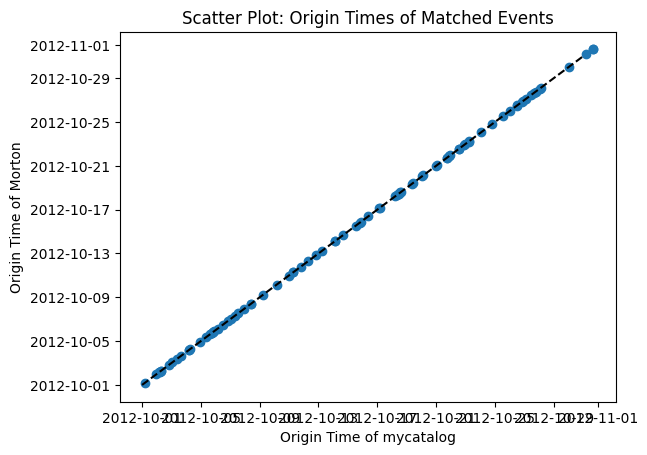

In [56]:
# Make lists for plotting the 1:1 line
x = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton))
y = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog,matched_times_morton)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

## Plot the Latitudes from mycatalog and Morton's catalog

Text(0.5, 1.0, 'Latitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

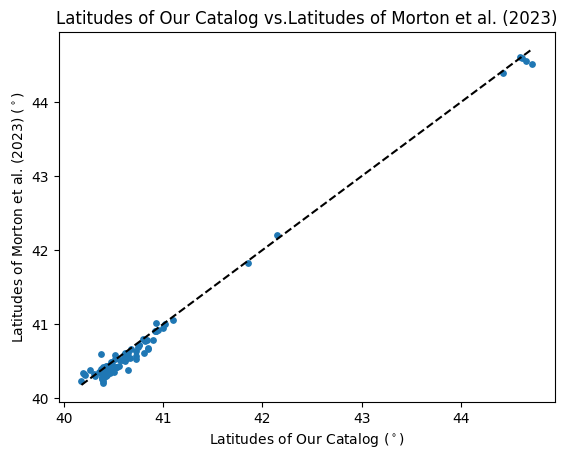

In [57]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog)
lat_max = max(lat_mycatalog)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog,lat_morton, s=15)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of Our Catalog ($^\circ$)')
plt.ylabel('Latitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Latitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

## Plot the longitudes from mycatalog and Morton's catalog

Text(0.5, 1.0, 'Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

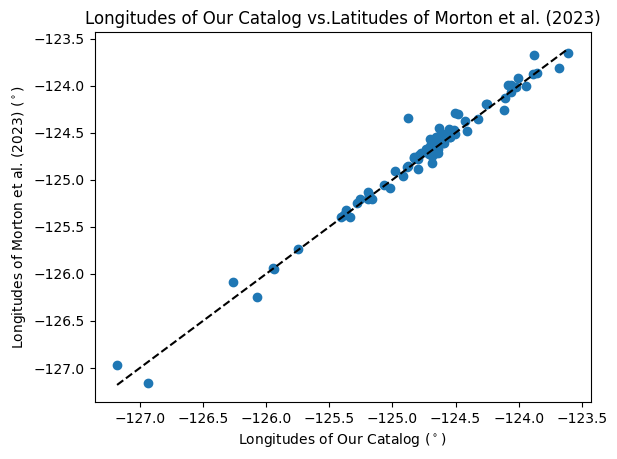

In [132]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog)
lon_max = max(lon_mycatalog)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog,lon_morton)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of Our Catalog ($^\circ$)')
plt.ylabel('Longitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

## Histograms
Make histograms of mycatalog vs. Morton's catalog

### Histogram: All of our catalog 

In [59]:
events_october = pd.read_csv('../data/events_201210.csv')

In [60]:
len(events_october),len(matched_events_mycatalog),len(unmatched_events_mycatalog)

(1039, 88, 951)

In [ ]:
events_october

In [ ]:
unmatched_events_mycatalog

In [ ]:
matched_events_mycatalog

In [ ]:
temp_time = matched_events_mycatalog.iloc[1]['time']
temp_time

In [ ]:
unmatched_events_mycatalog.loc[unmatched_events_mycatalog['time']==temp_time]

In [17]:
# Compare between matched_events_mycataloG ADN 

ls_these_events_exist_in_unmatched_events_mycatalog = []
ls_these_events_do_not_exist_in_unmatched_events_mycatalog =[]
for i in range(len(matched_events_mycatalog)):
    temp_time = matched_events_mycatalog.iloc[i]['time']
    temp = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['time'] == temp_time]
    
    if not temp.empty:  # Check if the DataFrame is not empty
        ls_these_events_exist_in_unmatched_events_mycatalog.append(temp_time)
    else:
        ls_these_events_do_not_exist_in_unmatched_events_mycatalog.append(temp_time)

In [ ]:
# Compare between 
ls_these_events_exist_in_unmatched_events_mycatalog = []
ls_these_events_do_not_exist_in_unmatched_events_mycatalog =[]
for i in range(len(matched_events_mycatalog)):
    temp_time = matched_events_mycatalog.iloc[i]['time']
    temp = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['time'] == temp_time]
    
    if not temp.empty:  # Check if the DataFrame is not empty
        ls_these_events_exist_in_unmatched_events_mycatalog.append(temp_time)
    else:
        ls_these_events_do_not_exist_in_unmatched_events_mycatalog.append(temp_time)

In [18]:
len(ls_these_events_exist_in_unmatched_events_mycatalog)

0

In [19]:
len(ls_these_events_do_not_exist_in_unmatched_events_mycatalog)

88

In [ ]:
# Plot the histogram of the number of picks for all events in events_october.csv
# plt.figure()
# fig,ax = plt.subplots(2,sharex=True)
# bins = np.linspace(5,26,20)
# ax[0].hist(events_october['picks'], bins=bins)

# # ax[0].set_xlabel('Number of Picks')
# ax[0].set_ylabel('Number of Events')
# ax[0].set_title('Histogram of Picks vs. the Number of Events')

# ax[1].hist(matched_events_mycatalog['picks'],bins=bins)
# ax[1].set_xlabel('Number of Picks')
# ax[1].set_ylabel('Number of Events')
# ax[1].set_title('Histogram of Matched Events: Picks vs. the Number of Events')

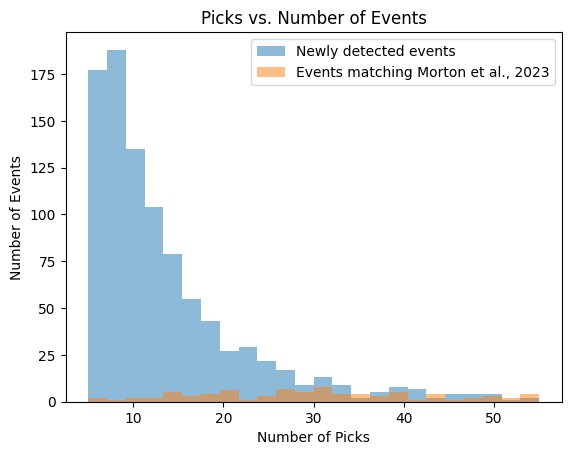

In [69]:
# Plot the same histogram but overlay the histograms
bins = np.linspace(5,55,25)

plt.hist(unmatched_events_mycatalog['picks'], bins=bins,  
         alpha=0.5, # the transaparency parameter 
         label='Newly detected events') 
  
plt.hist(matched_events_mycatalog['picks'], bins=bins,
         alpha=0.5, 
         label='Events matching Morton et al., 2023') 
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')  
plt.legend(loc='upper right') 
plt.title('Picks vs. Number of Events') 
plt.show()


### Histogram: Those matched with Morton 

Text(0.5, 1.0, 'Histogram of Matched Events: Picks vs. the Number of Events')

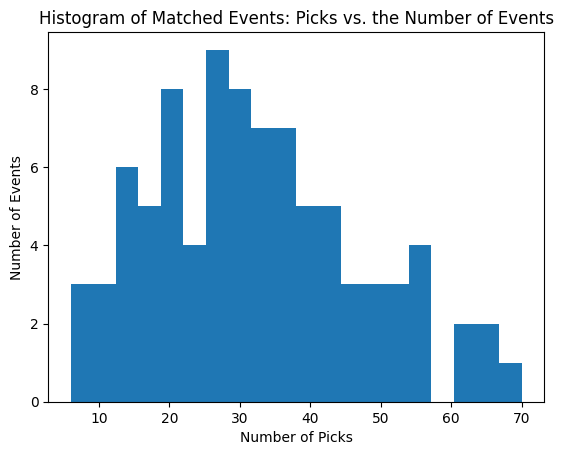

In [65]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
plt.hist(matched_events_mycatalog['picks'],bins=20)
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events: Picks vs. the Number of Events')

### Plot the waveforms of the Unmatched events in Morton's catalog

In [70]:
client = WaveformClient()
client2 = Client("IRIS")

In [ ]:
df = pd.read_csv('../data/all_picks_all_stations.csv')
df

In [ ]:
_df = df.drop_duplicates(subset='station_code')
_df

In [ ]:
networks_stas = np.array(_df[["station_network_code", "station_code" ]])
networks_stas

In [ ]:
new_events_lat_44_deg = unmatched_events_mycatalog.loc[(unmatched_events_mycatalog['latitude']>43.9)&(unmatched_events_mycatalog['latitude']<44.1)]
new_events_lat_44_deg

In [ ]:
unmatched_events_mycatalog

In [ ]:
# Plot the earthquake moveout for one of the unmatched events

idx = 0
event = unmatched_events_morton.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['LAT']
    olon = event['LON']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog: Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveouts for the unmatched events for Morton's catalog
for idx in range(len(unmatched_events_morton)):
    event = unmatched_events_morton.iloc[idx]
    otime = UTCDateTime(event['datetime'])
    distances = []

    # Assuming networks_stas is a list of tuples with network and station identifiers
    for network, station in networks_stas:
        try:
            sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                           starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
        except Exception as e:
            print(f"Failed to fetch for {network} {station} {otime}: {e}")
            continue

        slat = sta_inv.latitude
        slon = sta_inv.longitude
        olat = event['LAT']
        olon = event['LON']

        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)
        distances.append([network,station,dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])
    # print(distances)
    # print(otime)
    plt.figure(figsize=(10,20), dpi=150)
    for i, ii in enumerate(distances):
        st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
        st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
        st.filter(type='bandpass',freqmin=4,freqmax=15)

        trim_st = st.copy().trim(starttime = otime - 30, 
                    endtime = otime + 120)
        if len(trim_st)>0:
            trim_st = trim_st.normalize()
            offsets1  = ii[2]
            offsets2 = 0
    #         for ii in range(len(trim_st)):
            plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                     color = 'gray', alpha=0.7, lw=0.5)    
    #         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
    #                      if x['station'] == sta]
    #         if len(time_pick) > 0:
    #             for p in time_pick:
    #                 if p[1] == 'P':
            plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                         [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')

            plt.vlines(ii[2]/5, offsets1-5, 
                             offsets1+5, color='r')
    #                 else:
    #                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
    #                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
        else:                 
            pass 
    plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog: Origin Time={otime}")
    plt.xlabel('Time [sec]')
    plt.ylabel('Distance [km]')
    plt.grid()


    plt.show()

### Plot the waveforms of the unmatched events in our catalog (newly found events at the Mendocino Junction)

In [119]:
temp_event = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['idx']==1037]
new_event_example_picks = mycatalog_picks.loc[mycatalog_picks['event_idx']==new_event_example['idx']]
pick_sta = np.unique(new_event_example_picks['station'])
pick_sta

array(['FS01B', 'FS02B', 'FS04B', 'FS06B', 'FS09B', 'FS13B', 'FS16B',
       'FS20B', 'G02B', 'G03B', 'G10B', 'G11B', 'G19B', 'G20B', 'G26B',
       'JCC', 'K02D', 'M12B'], dtype=object)

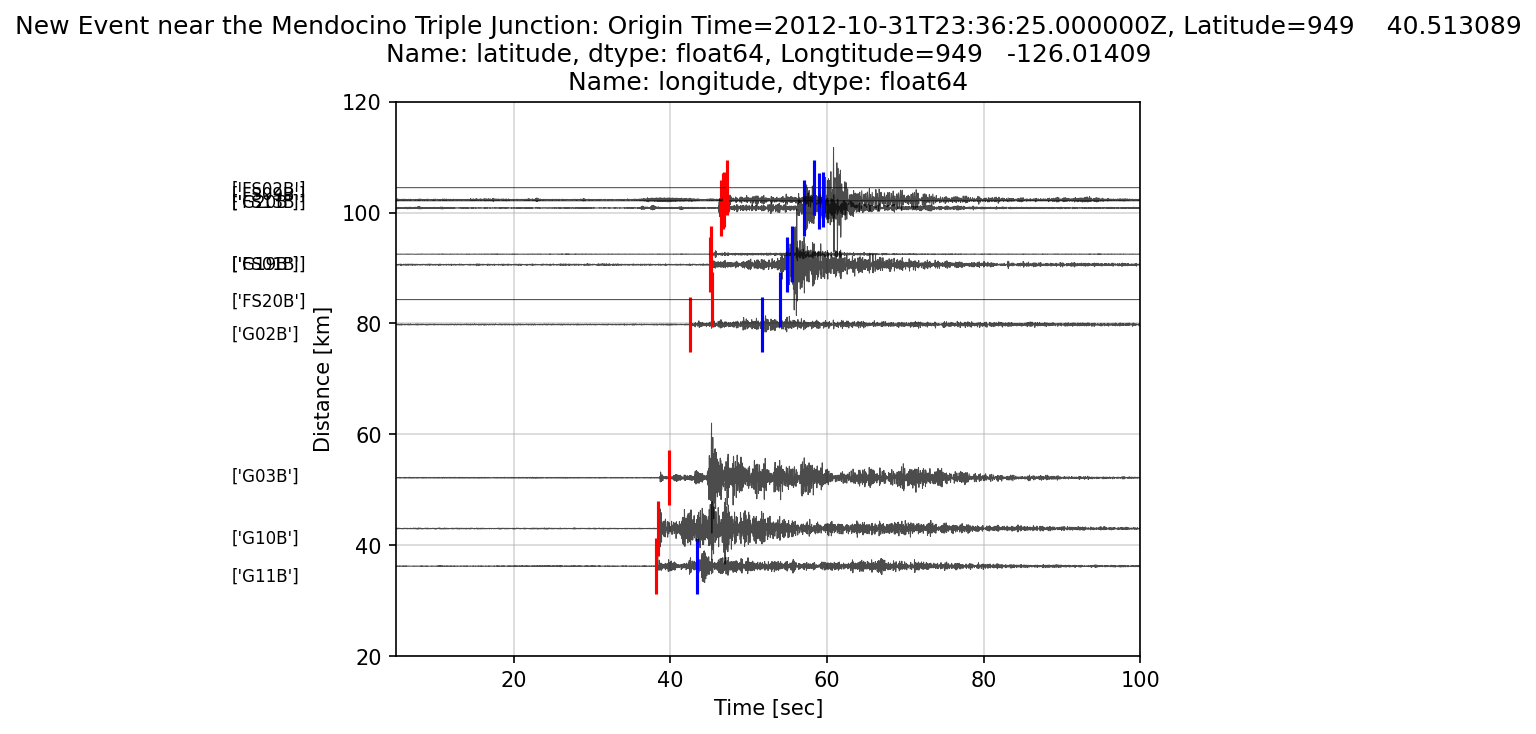

In [130]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=temp_event
# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(2012,10,31,23,36,25)
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -16, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"New Event near the Mendocino Triple Junction: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(20,120)
plt.xlim(5,100)

plt.grid(alpha=0.5)

plt.savefig("event_idx_1037.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
otime,trim_st[0].times()

In [ ]:
distances

### Plot the waveforms of the unmatched events in our catalog (newly found events offshore WA and Or)

In [84]:
unmatched_events_mycatalog[(unmatched_events_mycatalog['picks']>0) & (unmatched_events_mycatalog['latitude']>45) & (unmatched_events_mycatalog['latitude']<48)&(unmatched_events_mycatalog['longitude']>-127) & (unmatched_events_mycatalog['longitude']<-124.5)]

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
41,1016,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,245404,0.986945,D03D,P,1.349230e+09,2012-10-03 02:13:27.304245+00:00
242,4408,271,2012-10-09 03:00:47.021653+00:00,-81.640678,306.332599,48.046875,9,47.250980,-126.578494,48.046875,271,215002,1.263207,FISH,P,1.349752e+09,2012-10-09 03:00:47.021653+00:00
262,4694,292,2012-10-09 12:22:32.849978+00:00,53.722104,350.607554,35.546875,10,47.652055,-124.784903,35.546875,292,333367,-0.148732,FORK,P,1.349785e+09,2012-10-09 12:22:32.849978+00:00
386,6567,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,305492,-0.221122,DBO,P,1.350116e+09,2012-10-13 08:15:14.577893+00:00
482,8226,526,2012-10-16 04:39:14.022098+00:00,36.801756,199.833382,49.609375,7,46.297042,-125.022351,49.609375,526,232954,-0.909455,G03D,P,1.350362e+09,2012-10-16 04:39:14.022098+00:00
601,10391,658,2012-10-20 04:03:44.544631+00:00,57.106174,321.888664,0.390625,8,47.393481,-124.743583,0.390625,658,218509,0.669607,D03D,P,1.350706e+09,2012-10-20 04:03:44.544631+00:00
867,15069,951,2012-10-28 15:48:31.702822+00:00,56.260156,373.343342,42.578125,13,47.856308,-124.748182,42.578125,951,435667,-0.615726,BTB,S,1.351439e+09,2012-10-28 15:48:31.702822+00:00


In [95]:
event_WA_OR = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['idx']==49].iloc[0]
event_WA_OR

Unnamed: 0                                1016
idx                                         49
time          2012-10-03 02:13:27.304245+00:00
x                                   -35.955739
y                                   199.833382
z                                    46.484375
picks                                       10
latitude                             46.297087
longitude                          -125.966669
depth                                46.484375
event_idx                                   49
pick_idx                                245404
residual                              0.986945
station                                   D03D
phase                                        P
time_pick                        1349230447.55
datetime      2012-10-03 02:13:27.304245+00:00
Name: 41, dtype: object

In [97]:
new_event_example_picks_WA_OR = mycatalog_picks.loc[mycatalog_picks['idx']==event_WA_OR['idx']]
new_event_example_picks_WA_OR

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
1016,1016,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,245404,0.986945,D03D,P,1.349230e+09
1017,1017,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,174206,0.198437,FORK,P,1.349230e+09
1018,1018,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,517701,-0.622957,FORK,S,1.349230e+09
1019,1019,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,529394,-0.724059,J33B,S,1.349230e+09
1020,1020,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,343639,-0.008878,LEBA,P,1.349230e+09
1021,1021,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,642973,0.459402,LEBA,S,1.349230e+09
1022,1022,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,300510,0.154898,LZB,P,1.349230e+09
1023,1023,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,274624,1.274721,OFR,P,1.349230e+09
1024,1024,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,590338,-0.852592,OFR,S,1.349230e+09
1025,1025,49,2012-10-03 02:13:27.304245+00:00,-35.955739,199.833382,46.484375,10,46.297087,-125.966669,46.484375,49,355305,-0.865921,YOUB,P,1.349230e+09


In [98]:
pick_sta_WA_OR=np.unique(new_event_example_picks_WA_OR['station'])
pick_sta_WA_OR

array(['D03D', 'FORK', 'J33B', 'LEBA', 'LZB', 'OFR', 'YOUB'], dtype=object)

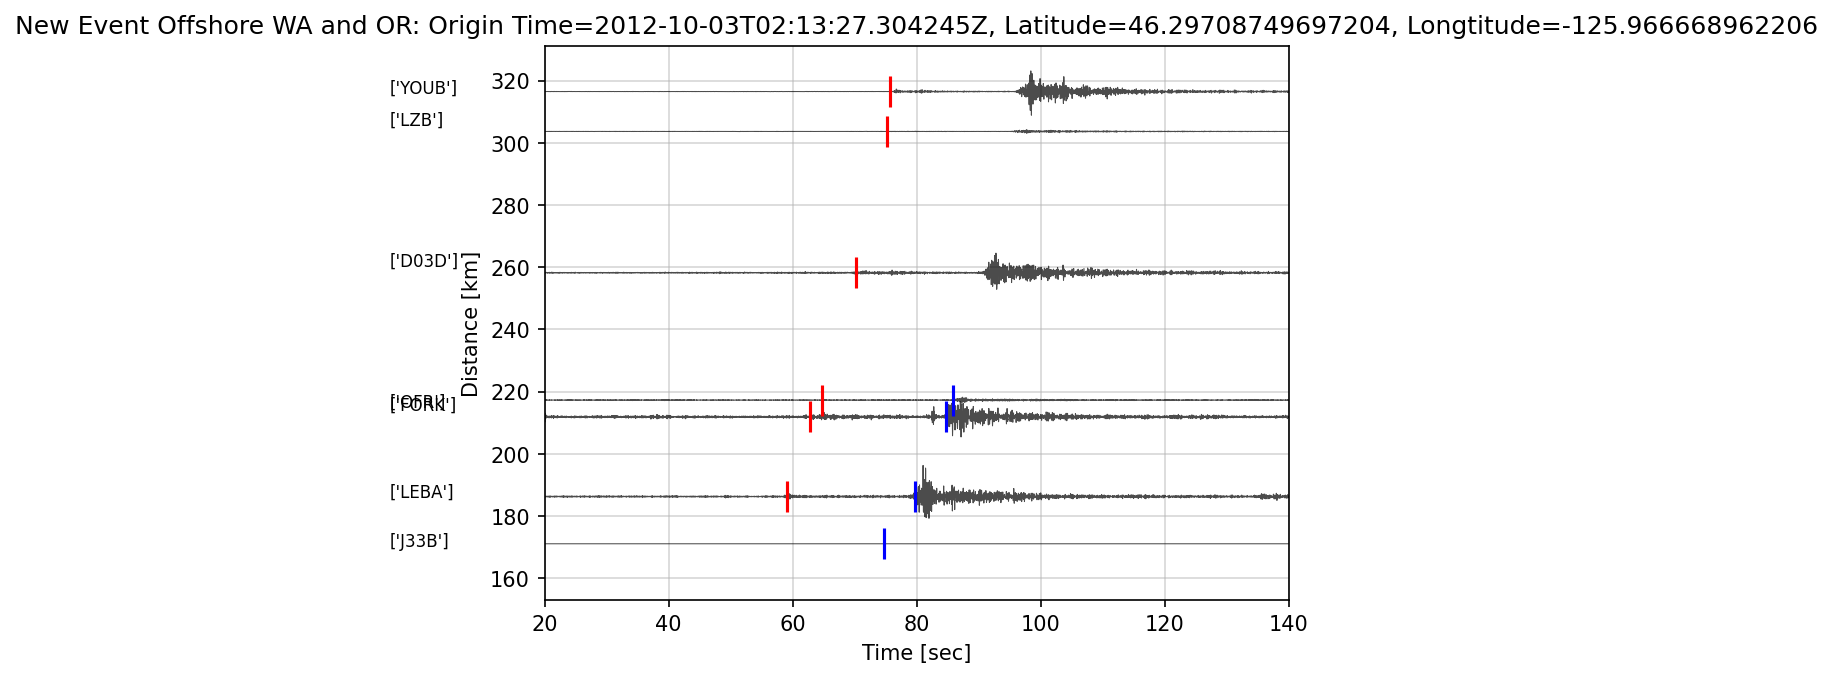

In [131]:

# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_WA_OR
new_event_example_picks = new_event_example_picks_WA_OR
pick_sta = pick_sta_WA_OR

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event_WA_OR['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"New Event Offshore WA and OR: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(20,120)
plt.xlim(20,140)

plt.grid(alpha=0.5)

plt.savefig("event_idx_49.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Plot the waveforms of the unmatched events in our catalog (newly found events offshore WA and OR) #2

In [77]:
event_WA_OR_idx_424 = unmatched_events_mycatalog.loc[unmatched_events_mycatalog['idx']==424].iloc[0]
event_WA_OR_idx_424

Unnamed: 0                                6567
idx                                        424
time          2012-10-13 08:15:14.577893+00:00
x                                    31.725652
y                                   142.395603
z                                    49.609375
picks                                        9
latitude                             45.780562
longitude                          -125.092052
depth                                49.609375
event_idx                                  424
pick_idx                                305492
residual                             -0.221122
station                                    DBO
phase                                        P
time_pick                       1350116162.465
datetime      2012-10-13 08:15:14.577893+00:00
Name: 386, dtype: object

In [104]:
new_event_example_picks_WA_OR_idx_424 = mycatalog_picks.loc[mycatalog_picks['event_idx']==event_WA_OR_idx_424['idx']]
new_event_example_picks_WA_OR_idx_424

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
6567,6567,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,305492,-0.221122,DBO,P,1.350116e+09
6568,6568,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,612076,0.559431,DBO,S,1.350116e+09
6569,6569,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,278274,1.204716,F04D,P,1.350116e+09
6570,6570,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,592590,-0.462393,F04D,S,1.350116e+09
6571,6571,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,98314,0.610358,G03D,P,1.350116e+09
6572,6572,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,458121,-0.598482,G03D,S,1.350116e+09
6573,6573,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,355128,-0.627736,I03D,P,1.350116e+09
6574,6574,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,226818,-0.887516,LZB,P,1.350116e+09
6575,6575,424,2012-10-13 08:15:14.577893+00:00,31.725652,142.395603,49.609375,9,45.780562,-125.092052,49.609375,424,630421,0.422744,OFR,S,1.350116e+09


In [105]:
pick_sta_WA_OR_idx_424=np.unique(new_event_example_picks_WA_OR_idx_424['station'])
pick_sta_WA_OR_idx_424

array(['DBO', 'F04D', 'G03D', 'I03D', 'LZB', 'OFR'], dtype=object)

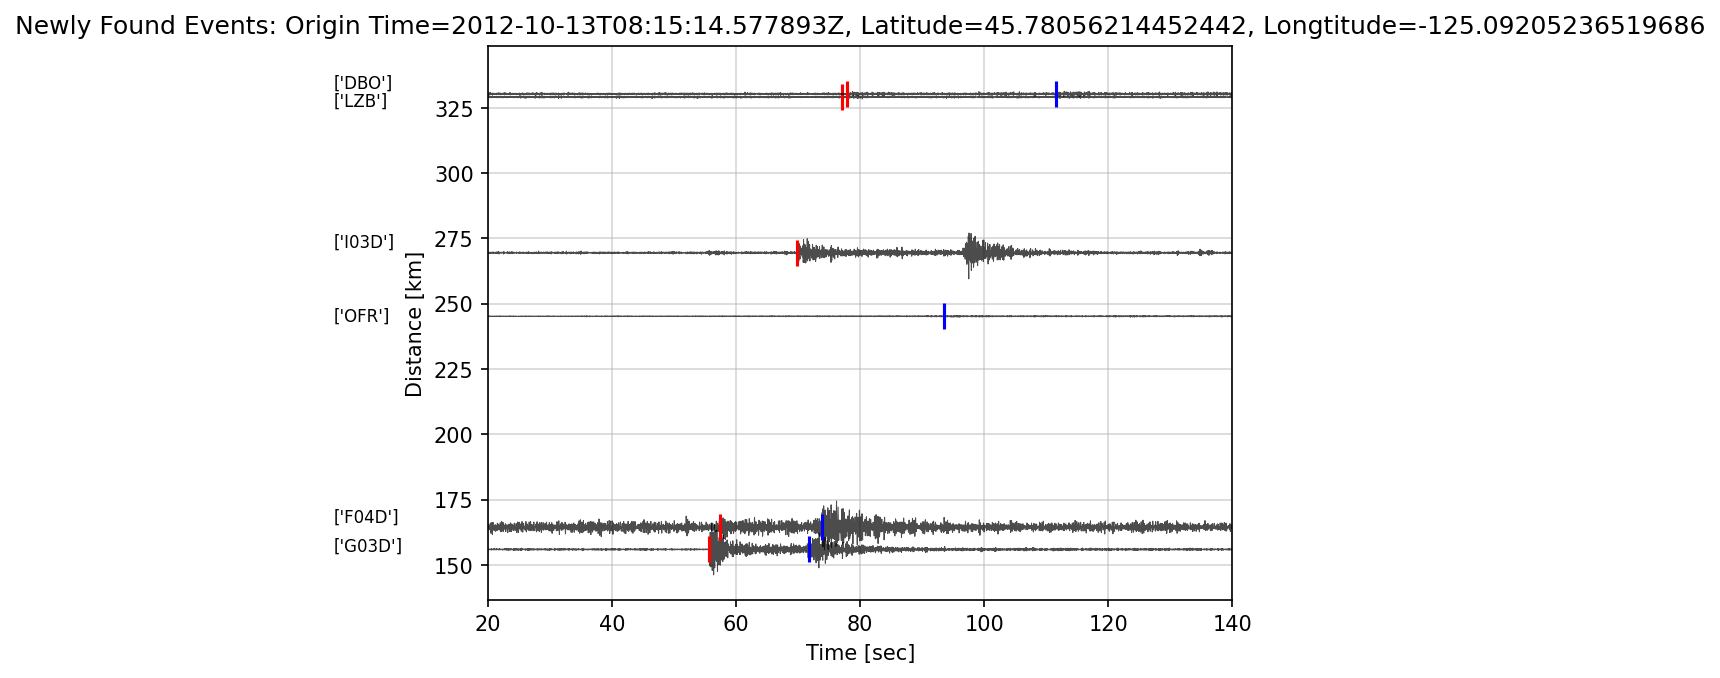

In [111]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_WA_OR_idx_424
new_event_example_picks = new_event_example_picks_WA_OR_idx_424
pick_sta = pick_sta_WA_OR_idx_424

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
#         wave=trim_st[0].data
#         wave=wave/np.std(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Newly Found Events: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(20,120)
plt.xlim(20,140)

plt.grid(alpha=0.5)

plt.savefig("event_idx_424.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Plot the earthquake moveout for one of the unmatched events for all stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
event = unmatched_events_mycatalog.iloc[idx]
otime = UTCDateTime(new_event_example['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# distances = distances[0:4]
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(80,120)
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
event = unmatched_events_mycatalog.iloc[idx]
otime = UTCDateTime(new_event_example['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:8]
# print(distances)
# print(otime)
plt.figure()
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(80,120)
plt.grid()


plt.show()

## Plot the earthquake moveout for one of the unmatched events for some stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events
idx = 0
event = unmatched_events_mycatalog.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveouts for the unmatched events for our catalog

ls_idx = np.arange(0,30) # Choose the indices of the events to plot
for idx in ls_idx:
    # Plot the earthquake moveout for one of the unmatched events

    event = unmatched_events_mycatalog.iloc[idx]
    otime = UTCDateTime(event['datetime'])
    distances = []

    # Assuming networks_stas is a list of tuples with network and station identifiers
    for network, station in networks_stas:
        try:
            sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                           starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
        except Exception as e:
            print(f"Failed to fetch for {network} {station} {otime}: {e}")
            continue

        slat = sta_inv.latitude
        slon = sta_inv.longitude
        olat = event['latitude']
        olon = event['longitude']

        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)
        distances.append([network,station,dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])
    # print(distances)
    # print(otime)
    plt.figure(figsize=(10,20), dpi=150)
    for i, ii in enumerate(distances):
        st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
        st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
        st.filter(type='bandpass',freqmin=4,freqmax=15)

        trim_st = st.copy().trim(starttime = otime - 30, 
                    endtime = otime + 120)
        if len(trim_st)>0:
            trim_st = trim_st.normalize()
            offsets1  = ii[2]
            offsets2 = 0
    #         for ii in range(len(trim_st)):
            plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                     color = 'gray', alpha=0.7, lw=0.5)    
    #         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
    #                      if x['station'] == sta]
    #         if len(time_pick) > 0:
    #             for p in time_pick:
    #                 if p[1] == 'P':
            plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                         [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')

            plt.vlines(ii[2]/5, offsets1-5, 
                             offsets1+5, color='r')
    #                 else:
    #                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
    #                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
        else:                 
            pass 
    plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
    plt.xlabel('Time [sec]')
    plt.ylabel('Distance [km]')
    plt.grid()


    plt.show()

## Plot the earthquake moveout for one of the matched events for all stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events
idx = 0
event = matched_events_mycatalog.iloc[idx]
otime = UTCDateTime(event['datetime'])
picks = 
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()

In [ ]:
mycatalog